# Evaluation

This notebook evaluates the QRNN and BMCI method against the results obtained from MCMC. 

In [1]:
import numpy as np
import matplotlib_settings
import matplotlib.pyplot as plt
from atms import load_file
from typhon.retrieval.qrnn import QRNN
from typhon.retrieval.bmci import BMCI

Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so


Using Theano backend.


In [2]:
root_group, v_tbs, v_cwv_true, v_cwv, v_h2o = load_file("data/mcmc_retrievals_5.nc")
tbs_test      = np.copy(v_tbs)
cwv_mcmc_true = np.copy(v_cwv_true)
cwv_mcmc      = np.copy(v_cwv)

## MCMC Retrieval Quality

To make sure that the MCMC retrieval has converged and provides reasonable stastics, the scale reduction factor $\hat{R}$ and the effective sample size as described in Bayesian Data Analysis (3rd Edition, Chapter 11.4, 11.5) are computed. If the scale reduction factor is above $1.1$ or the effective sample size below 100, the result is discarded.

In [3]:
from typhon.retrieval.mcmc import r_factor, effective_sample_size

n = cwv_mcmc_true.shape[0]
r_vals = np.zeros(n)
ess    = np.zeros(n)
inds   = []

for i in range(n):
    cwv = np.asarray(cwv_mcmc[i, :].reshape(8, -1))
    r_vals[i] = r_factor(cwv)
    ess[i]    = effective_sample_size(cwv)
    if r_vals[i] < 1.1 and ess[i] > 100.0:
        inds += [i]
        
ess = ess[inds]
r_vals = r_vals[inds]
tbs_test      = tbs_test[inds, :]
cwv_mcmc_true = cwv_mcmc_true[inds]
cwv_mcmc      = cwv_mcmc[inds]

The observations in the test data do not contain noise, so it is added after loading.

In [10]:
x_test_5 = np.load("data/x_test_5.npy")[:10000, :]
y_test_5 = np.load("data/y_test_5.npy")[:10000]
x_test_5 += np.random.randn(*x_test_5.shape)

## Estimating the Posterior Distribution

For illustration purpose, we generate a plot of posterior CDFs for a small number of retrieval cases. The cases chosen are the 1st, 50th and 99th percentile of the distribution of CWV values.                                                                                                                                                                                  

In [11]:
qrnn          = QRNN.load("models/qrnn_1_1000000")
qrnn_ensemble = QRNN.load("models/qrnn_5_1000000")

In [12]:
x_train = np.load("data/x_train_5.npy")
y_train = np.load("data/y_train_5.npy")
bmci = BMCI(x_train, y_train, np.diag(np.ones(5)))

In [13]:
n = cwv_mcmc_true.shape[0]
ks_qrnn = np.zeros(n)
ks_bmci = np.zeros(n)
for i in range(n):
    if i % 100 == 0:
        print("progress: " + str(i))
    ys, edges = np.histogram(cwv_mcmc[i, :], bins = 50)
    ys = np.cumsum(ys)
    ys = ys / ys[-1]
    xs = 0.5 * (edges[1:] + edges [:-1])
    
    # bmci
    xs_bmci, ys_bmci = bmci.cdf(tbs_test[i, :])
    ks_bmci[i] = np.max(np.abs(ys - np.interp(xs, xs_bmci, ys_bmci)))
   
    # qrnn
    xs_qrnn, ys_qrnn = qrnn.cdf(tbs_test[i, :])
    ks_qrnn[i] = np.max(np.abs(ys - np.interp(xs, xs_qrnn, ys_qrnn)))
    

progress: 0
progress: 100
progress: 200
progress: 300
progress: 400
progress: 500
progress: 600
progress: 700
progress: 800
progress: 900
progress: 1000
progress: 1100
progress: 1200
progress: 1300
progress: 1400
progress: 1500
progress: 1600
progress: 1700
progress: 1800
progress: 1900
progress: 2000
progress: 2100
progress: 2200
progress: 2300
progress: 2400
progress: 2500
progress: 2600
progress: 2700
progress: 2800
progress: 2900
progress: 3000
progress: 3100
progress: 3200
progress: 3300
progress: 3400
progress: 3500
progress: 3600
progress: 3700
progress: 3800
progress: 3900
progress: 4000
progress: 4100
progress: 4200
progress: 4300
progress: 4400
progress: 4500
progress: 4600
progress: 4700
progress: 4800
progress: 4900
progress: 5000
progress: 5100
progress: 5200
progress: 5300
progress: 5400
progress: 5500
progress: 5600
progress: 5700
progress: 5800
progress: 5900
progress: 6000
progress: 6100
progress: 6200
progress: 6300
progress: 6400
progress: 6500
progress: 6600
progres


Bad key "axes.formatter.min_exponent" on line 233 in
/home/simonpf/.config/matplotlib/paper.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'figure.max_open_warning', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


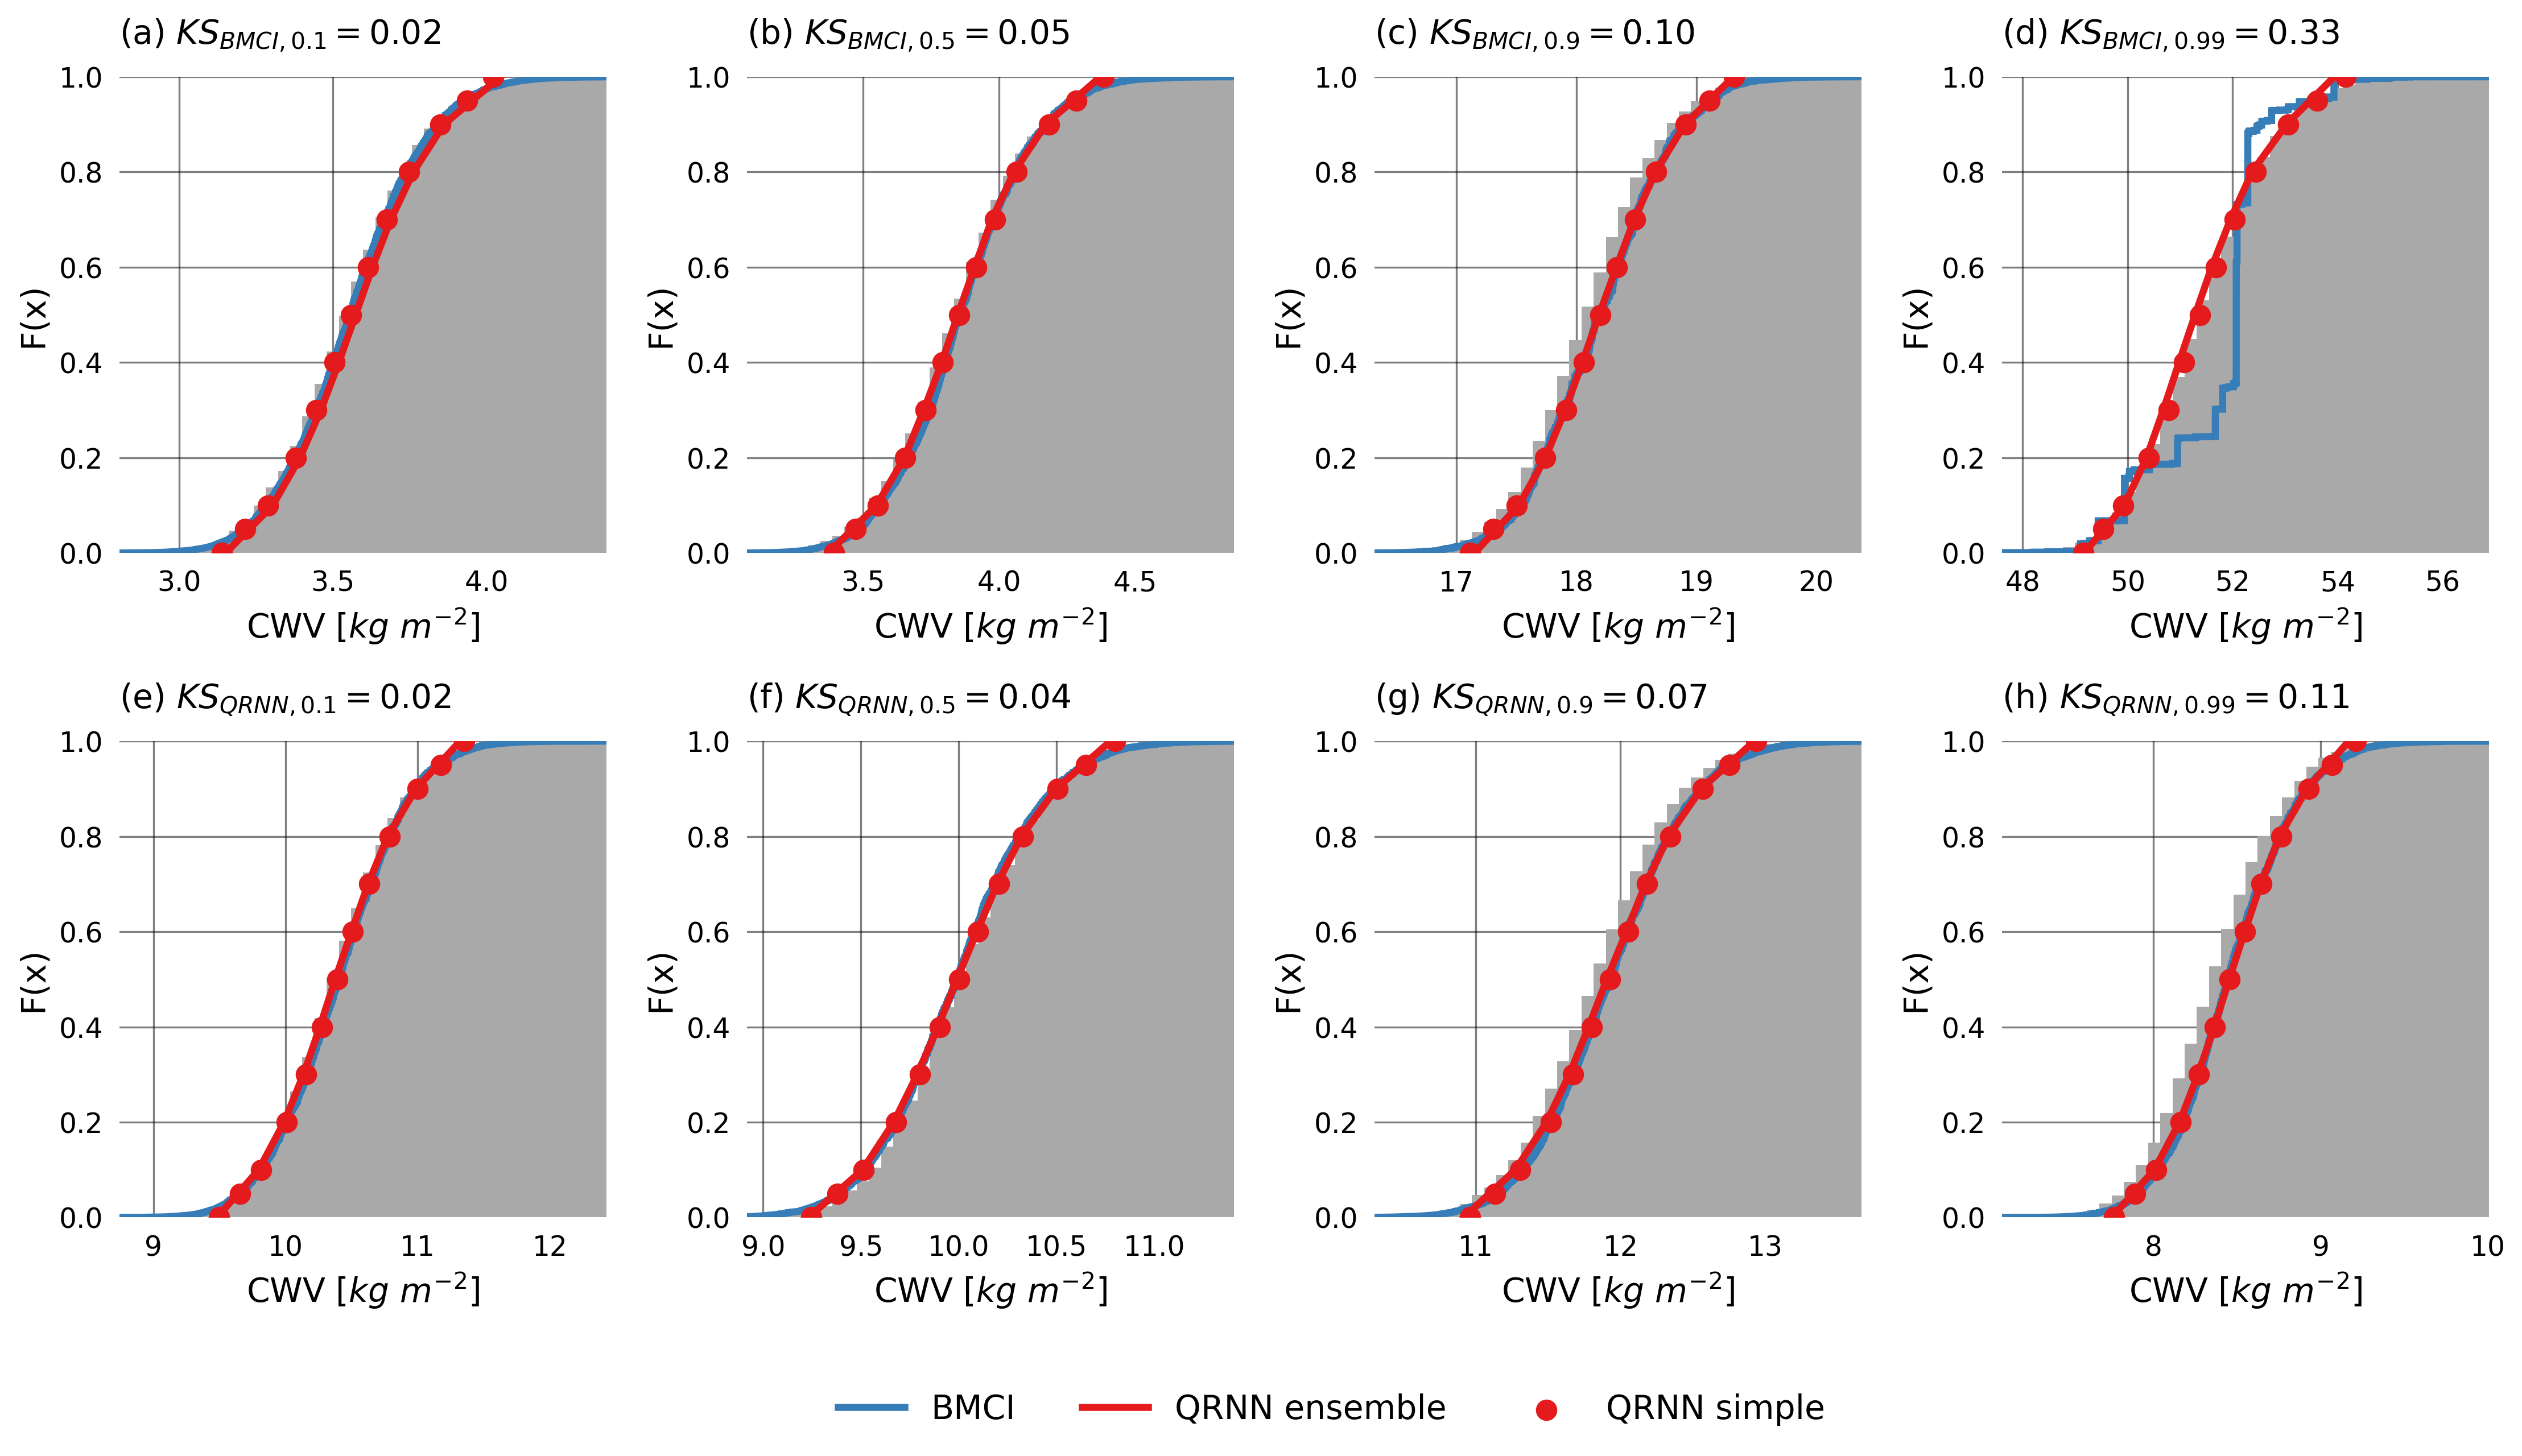

In [46]:
quantiles = [0.1, 0.5, 0.9, 0.99]
plt.style.use("/home/simonpf/.config/matplotlib/paper")
f, axs = plt.subplots(2, 4, figsize = (15, 8))
prefixes = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]

inds = np.argsort(ks_bmci)
for i in range(len(quantiles)):
    ax = axs[0, i]
    j = inds[int(quantiles[i] * (inds.size - 1))]
    cts, bins, _ = ax.hist(cwv_mcmc[j, :], cumulative = True, normed = True,
                           bins = 40, color = 'darkgrey')
    
    x, qs = bmci.cdf(tbs_test[j, :].reshape(1, -1))
    ax.plot(x, qs, lw = 3, label = "BMCI", c = "C2")
    
    x, qs = qrnn.cdf(tbs_test[j,:].reshape(1, -1))
    ax.plot(x, qs, lw = 3, label = "QRNN ensemble", c = "C1")
    
    x, qs = qrnn_ensemble.cdf(tbs_test[j,:].reshape(1, -1))
    ax.scatter(x, qs, lw = 3, label = "QRNN simple", c = "C1", marker = "o", zorder = 10)
    
    ks = ks_bmci[inds[int(quantiles[i] * (inds.size - 1))]]
    ax.set_title(prefixes[i] + r" $KS_{{BMCI, {0:g}}} = {1:.2f}$".format(quantiles[i], ks), loc = "left")
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_xlabel("CWV $[kg$ $m^{-2}]$")
    ax.set_ylabel("F(x)")
    ax.set_ylim([0, 1.0])
    
inds = np.argsort(ks_qrnn)
for i in range(len(quantiles)):
    ax = axs[1, i]
    j = inds[int(quantiles[i] * (inds.size - 1))]
    cts, bins, _ = ax.hist(cwv_mcmc[j, :], cumulative = True, normed = True,
                           bins = 40, color = 'darkgrey')
    
    x, qs = bmci.cdf(tbs_test[j, :].reshape(1, -1))
    ax.plot(x, qs, lw = 3, label = "BMCI", c = "C2")
    
    x, qs = qrnn.cdf(tbs_test[j,:].reshape(1, -1))
    ax.plot(x, qs, lw = 3, label = "QRNN ensemble", c = "C1")
    
    x, qs = qrnn_ensemble.cdf(tbs_test[j,:].reshape(1, -1))
    ax.scatter(x, qs, lw = 3, label = "QRNN simple", c = "C1", marker = "o", zorder = 10)
    
    ks = ks_qrnn[inds[int(quantiles[i] * (inds.size - 1))]]
    ax.set_title(prefixes[4 + i] + r" $KS_{{QRNN, {0:g}}} = {1:.2f}$".format(quantiles[i], ks), loc = "left")
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_xlabel("CWV $[kg$ $m^{-2}]$")
    ax.set_ylabel("F(x)")
    ax.set_ylim([0, 1.0])
    
axs.ravel()[5].legend(loc = 'lower center', bbox_to_anchor = (1.2, -0.5),
                      fancybox = False, ncol = 3)
f.tight_layout()
f.savefig("plots/posterior_cdfs.pdf", bbox_inches='tight')

## Quantile Distributions

To further assess the predictions of the conditional quantiles, we compute for each quantile $\tau$ which fraction of the MCMC samples lies to the left of it. We plot the resulting distributions which should peak
around the corresponding $\tau$ value.

In [24]:
quantiles = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]).reshape(1, -1)
qs_bmci = bmci.predict_quantiles(tbs_test, quantiles)
qs_qrnn          = qrnn.predict(tbs_test)
qs_qrnn_ensemble = qrnn_ensemble.predict(tbs_test)

In [25]:
qdist_bmci = np.sum(cwv_mcmc[:, :, np.newaxis] < qs_bmci.reshape(-1, 1, 11), axis = 1)
qdist_bmci = qdist_bmci / cwv_mcmc.shape[1]
qdist_qrnn = np.sum(cwv_mcmc[:, :, np.newaxis] < qs_qrnn.reshape(-1, 1, 11), axis = 1)
qdist_qrnn = qdist_qrnn /cwv_mcmc.shape[1]
qdist_qrnn_ensemble = np.sum(cwv_mcmc[:, :, np.newaxis] < qs_qrnn_ensemble.reshape(-1, 1, 11), axis = 1)
qdist_qrnn_ensemble = qdist_qrnn_ensemble /cwv_mcmc.shape[1]

The plot is a bit more involved an needs quite some code for the setup.

In [26]:
qdist_qrnn = np.sum(cwv_mcmc[:, :, np.newaxis] < qs_qrnn.reshape(-1, 1, 11), axis = 1)
qdist_qrnn = qdist_qrnn /cwv_mcmc.shape[1]

In [42]:
import seaborn as sns
sns.reset_orig()
import matplotlib.cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm, Normalize, to_rgb
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
cdict = {"#E24A33" : ((0.0, 1.0, 1.0),
                     (1.0, 0.0, 0.0)),
         "#348ABD" : ((0.0, 0.0, 0.0),
                     (1.0, 1.0, 1.0))}

seq = sns.color_palette("BrBG", 3)
colors = [to_rgb("#cc712e"), to_rgb("#712ecc")]
colors = [to_rgb("#31a354"), to_rgb("#41b6c4"), to_rgb("#253494")]
#colors = [seq[0], seq[-1]]
cmap = LinearSegmentedColormap.from_list("r2b", colors, N = 10)


bounds = 0.5 * (quantiles[0, 1:] + quantiles[0, :-1])
norm = BoundaryNorm(bounds, 9)
#norm = Normalize(vmin = 0.0, vmax = 1.0)
sm = ScalarMappable(norm = norm, cmap = cmap)
colors = sm.to_rgba(quantiles)

In [43]:

from matplotlib.legend_handler import HandlerTuple

# Taken from: https://stackoverflow.com/questions/31544489/two-line-styles-in-legend
# SO awesomeness.
class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

In [44]:
[str(x) for x in quantiles.ravel()]

['0.05', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '0.95']

/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


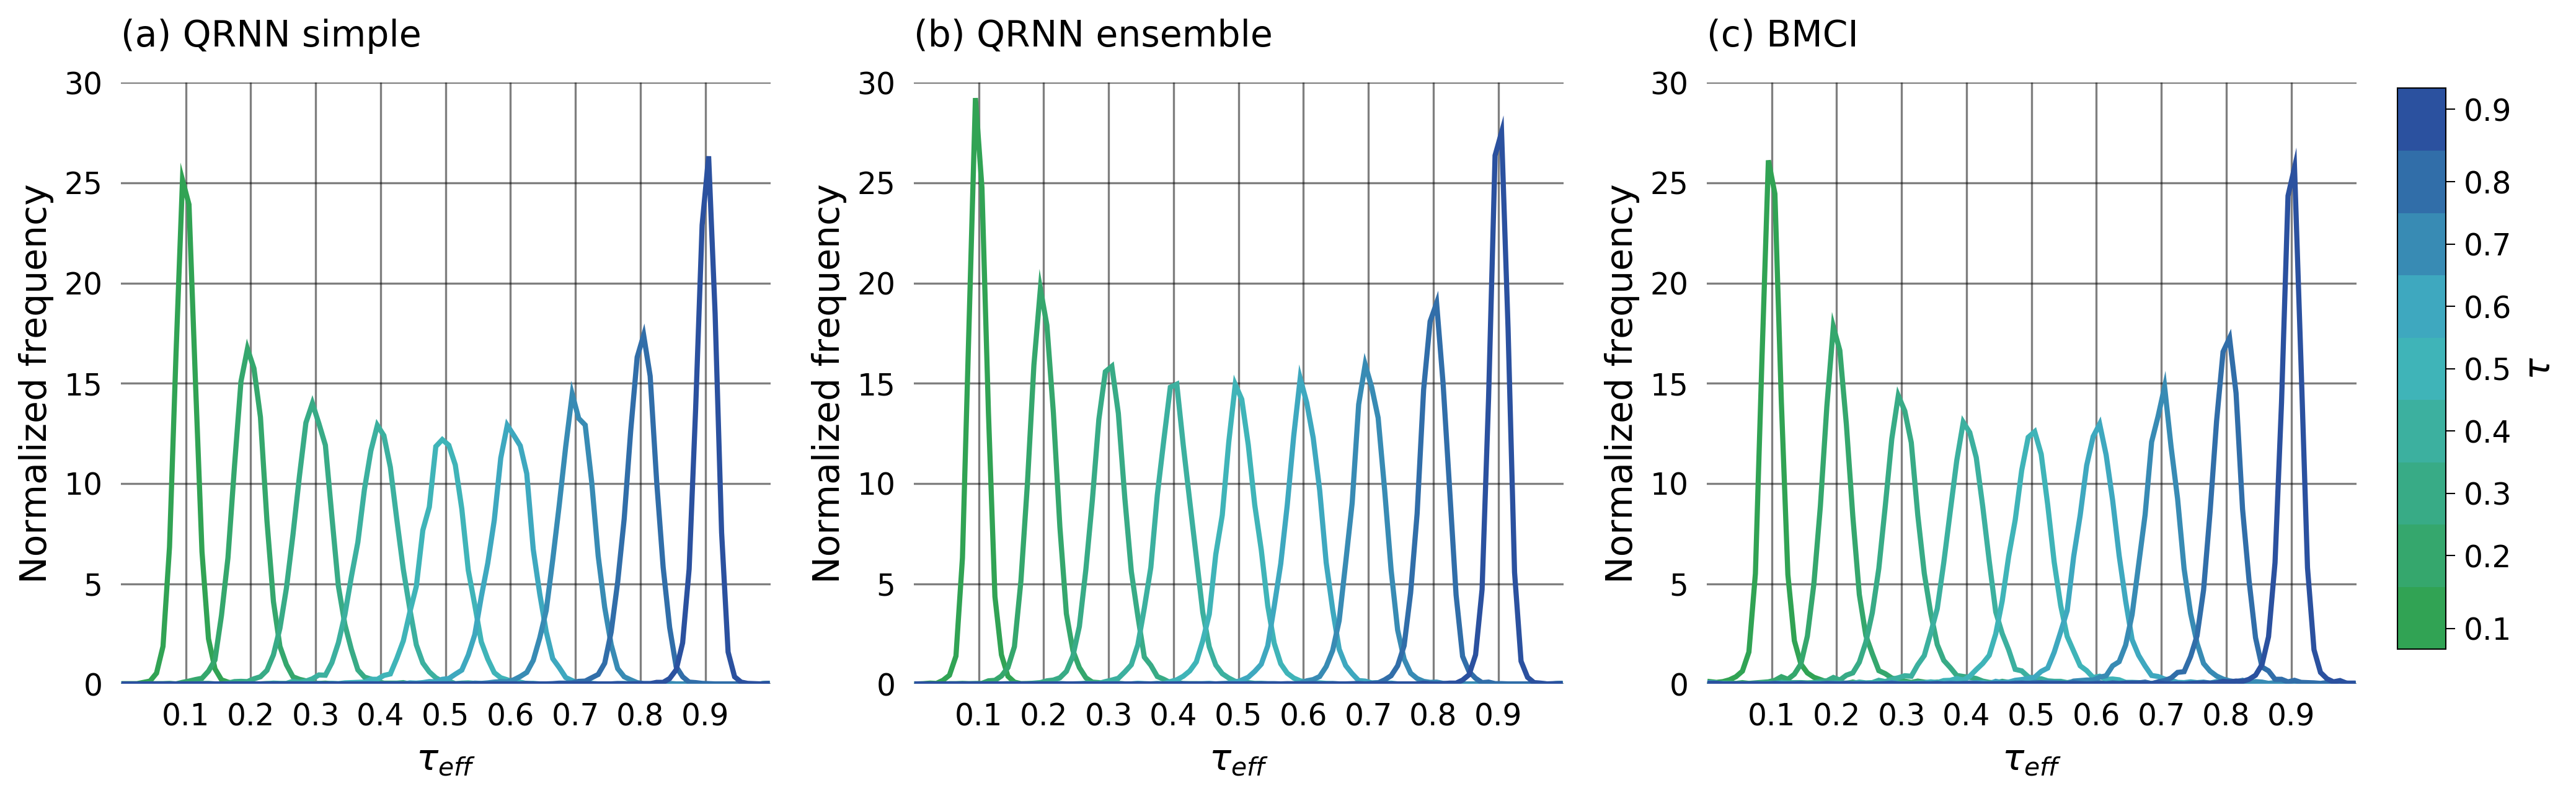

In [48]:
fig, axs = plt.subplots(1, 3, figsize = (13, 4.5))

bins = np.linspace(0.0, 1.0, 101)
x = 0.5 * (bins[1:] + bins[:-1])
ptchs_qrnn_ensemble = []
ptchs_qrnn = []
ptchs_bmci = []

quantiles = np.array([[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]])

for i in range(1, 10):
    cts_qrnn, _ = np.histogram(qdist_qrnn[:, i], bins = bins, normed = True)
    ps = axs[0].plot(x, cts_qrnn, c = colors[0][i, :], ls = "-", lw = 2)
    #ptchs_qrnn += ps
    #cts_qrnn, _ = np.histogram(qdist_qrnn[:, i], bins = bins)
    #cts_bmci, _ = np.histogram(qdist_bmci[:, i], bins = bins)
    #ps = axs[0].plot(x, cts_bmci, c = colors[0][i, :], ls = "--", lw = 2)
    ptchs_bmci += ps
sm.set_array(quantiles)
axs[0].set_xticks(np.arange(0.1, 1.0, 0.1))
axs[0].set_title("(a) QRNN simple", loc = "left")
axs[0].set_ylim([0, 30.0])
axs[0].set_xlim([0, 1.0])
axs[0].set_xlabel(r"$\tau_{eff}$")
axs[0].set_ylabel("Normalized frequency")

for i in range(1, 10):
    cts_qrnn_ensemble, _ = np.histogram(qdist_qrnn_ensemble[:, i], bins = bins, normed = True)
    ps = axs[1].plot(x, cts_qrnn_ensemble, c = colors[0][i, :], ls = "-", lw = 2)
    #ptchs_qrnn_ensemble += ps
    #cts_qrnn, _ = np.histogram(qdist_qrnn[:, i], bins = bins)
    #cts_bmci, _ = np.histogram(qdist_bmci[:, i], bins = bins)
    #ps = axs[1].plot(x, cts_bmci, c = colors[0][i, :], ls = "--", lw = 2)
    ptchs_bmci += ps
axs[1].set_xticks(np.arange(0.1, 1.0, 0.1))
axs[1].set_ylim([0, 30.0])
axs[1].set_xlim([0, 1.0])
axs[1].set_title("(b) QRNN ensemble", loc = "left")
axs[1].set_xlabel(r"$\tau_{eff}$")
axs[1].set_ylabel("Normalized frequency")

for i in range(1, 10):
    #cts_qrnn_ensemble, _ = np.histogram(qdist_qrnn_ensemble[:, i], bins = bins)
    #ps = axs[2].plot(x, cts_qrnn_ensemble, c = colors[0][i, :], ls = "-", lw = 2)
    #ptchs_qrnn_ensemble += ps
    #cts_qrnn, _ = np.histogram(qdist_qrnn[:, i], bins = bins)
    cts_bmci, _ = np.histogram(qdist_bmci[:, i], bins = bins, normed = True)
    ps = axs[2].plot(x, cts_bmci, c = colors[0][i, :], lw = 2)
    ptchs_bmci += ps
    
axs[2].set_xticks(np.arange(0.1, 1.0, 0.1))
axs[2].set_ylim([0, 30.0])
axs[2].set_xlim([0, 1.0])
axs[2].set_title("(c) BMCI", loc = "left")
axs[2].set_xlabel(r"$\tau_{eff}$")
axs[2].set_ylabel("Normalized frequency")



#axs[1].legend(((ptchs_qrnn_ensemble[0], ptchs_qrnn_ensemble[-1]),
#                (ptchs_bmci[0], ptchs_bmci[-1])),
#                ('QRNN', 'BMCI'),
#                handler_map = {tuple : HandlerTupleVertical()},
#                fancybox = False,
#                loc = "upper center", bbox_to_anchor = [-0.1, 1.30], ncol = 2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.00, 0.2, 0.02, 0.67])
cbar = fig.colorbar(sm,  ticks = quantiles[0, 1:10], cax = cbar_ax)
cbar.ax.set_xticklabels([str(x) for x in quantiles[0, :]])
cbar.ax.set_ylabel(r"$\tau$")

plt.tight_layout()


fig.savefig("plots/quantile_fractions_3.pdf", bbox_inches = "tight")

In [49]:
[str(x) for x in quantiles[0, :]]

['0.05', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '0.95']

/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


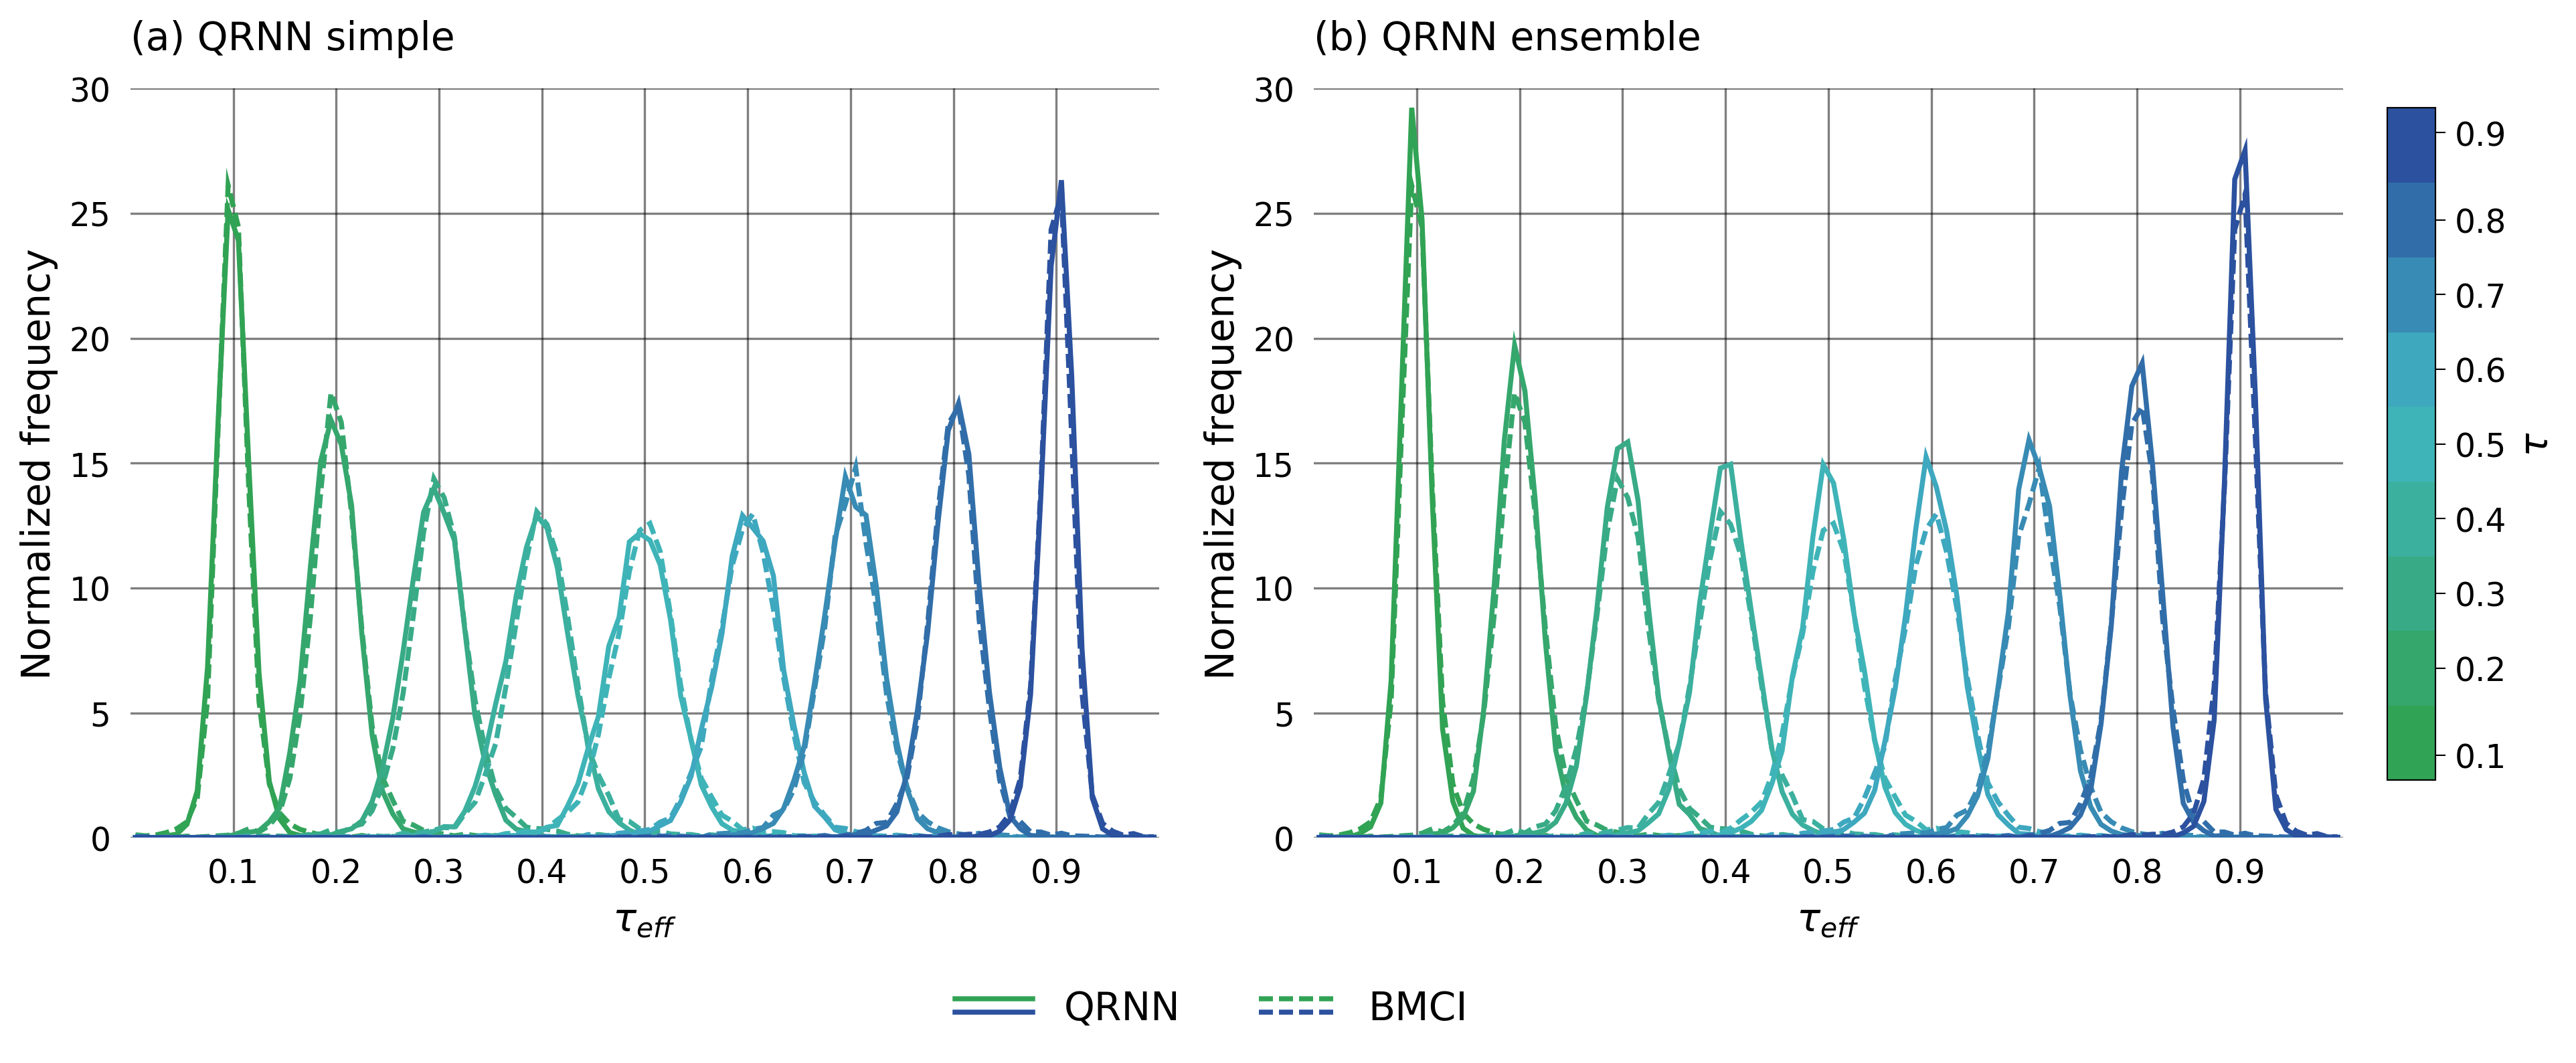

In [52]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

bins = np.linspace(0.0, 1.0, 101)
x = 0.5 * (bins[1:] + bins[:-1])
ptchs_qrnn_ensemble = []
ptchs_qrnn = []
ptchs_bmci = []

for i in range(1, 10):
    cts_qrnn, _ = np.histogram(qdist_qrnn[:, i], bins = bins, normed = True)
    ps = axs[0].plot(x, cts_qrnn, c = colors[0][i, :], ls = "-", lw = 1.8)
    ptchs_qrnn += ps
    cts_qrnn, _ = np.histogram(qdist_qrnn[:, i], bins = bins, normed = True)
    cts_bmci, _ = np.histogram(qdist_bmci[:, i], bins = bins, normed = True)
    ps = axs[0].plot(x, cts_bmci, c = colors[0][i, :], ls = "--", lw = 1.8)
    ptchs_bmci += ps
sm.set_array(quantiles)
axs[0].set_xticks(np.arange(0.1, 1.0, 0.1))
axs[0].set_title("(a) QRNN simple", loc = "left")
axs[0].set_ylim([0, 30.0])
axs[0].set_xlim([0, 1.0])
axs[0].set_xlabel(r"$\tau_{eff}$")
axs[0].set_ylabel("Normalized frequency")

for i in range(1, 10):
    cts_qrnn_ensemble, _ = np.histogram(qdist_qrnn_ensemble[:, i], bins = bins, normed = True)
    ps = axs[1].plot(x, cts_qrnn_ensemble, c = colors[0][i, :], ls = "-", lw = 1.8)
    ptchs_qrnn_ensemble += ps
    cts_qrnn, _ = np.histogram(qdist_qrnn[:, i], bins = bins, normed = True)
    cts_bmci, _ = np.histogram(qdist_bmci[:, i], bins = bins, normed = True)
    ps = axs[1].plot(x, cts_bmci, c = colors[0][i, :], ls = "--", lw = 1.8)
    ptchs_bmci += ps
axs[1].set_xticks(np.arange(0.1, 1.0, 0.1))
axs[1].set_ylim([0, 30.0])
axs[1].set_xlim([0, 1.0])
axs[1].set_title("(b) QRNN ensemble", loc = "left")
axs[1].set_xlabel(r"$\tau_{eff}$")
axs[1].set_ylabel("Normalized frequency")

axs[1].legend(((ptchs_qrnn_ensemble[0], ptchs_qrnn_ensemble[-1]),
                (ptchs_bmci[0], ptchs_bmci[-1])),
                ('QRNN', 'BMCI'),
                handler_map = {tuple : HandlerTupleVertical()},
                fancybox = False,
                loc = "lower center", bbox_to_anchor = [-0.1, -0.3], ncol = 2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.2, 0.02, 0.67])
cbar = fig.colorbar(sm,  ticks = quantiles[1:10], cax = cbar_ax)
cbar = fig.colorbar(sm,  ticks = quantiles[0, 1:10], cax = cbar_ax)
cbar.ax.set_xticklabels([str(x) for x in quantiles.ravel()])
cbar.ax.set_ylabel(r"$\tau$")

plt.tight_layout()


fig.savefig("plots/quantile_fractions.pdf", bbox_inches = "tight")

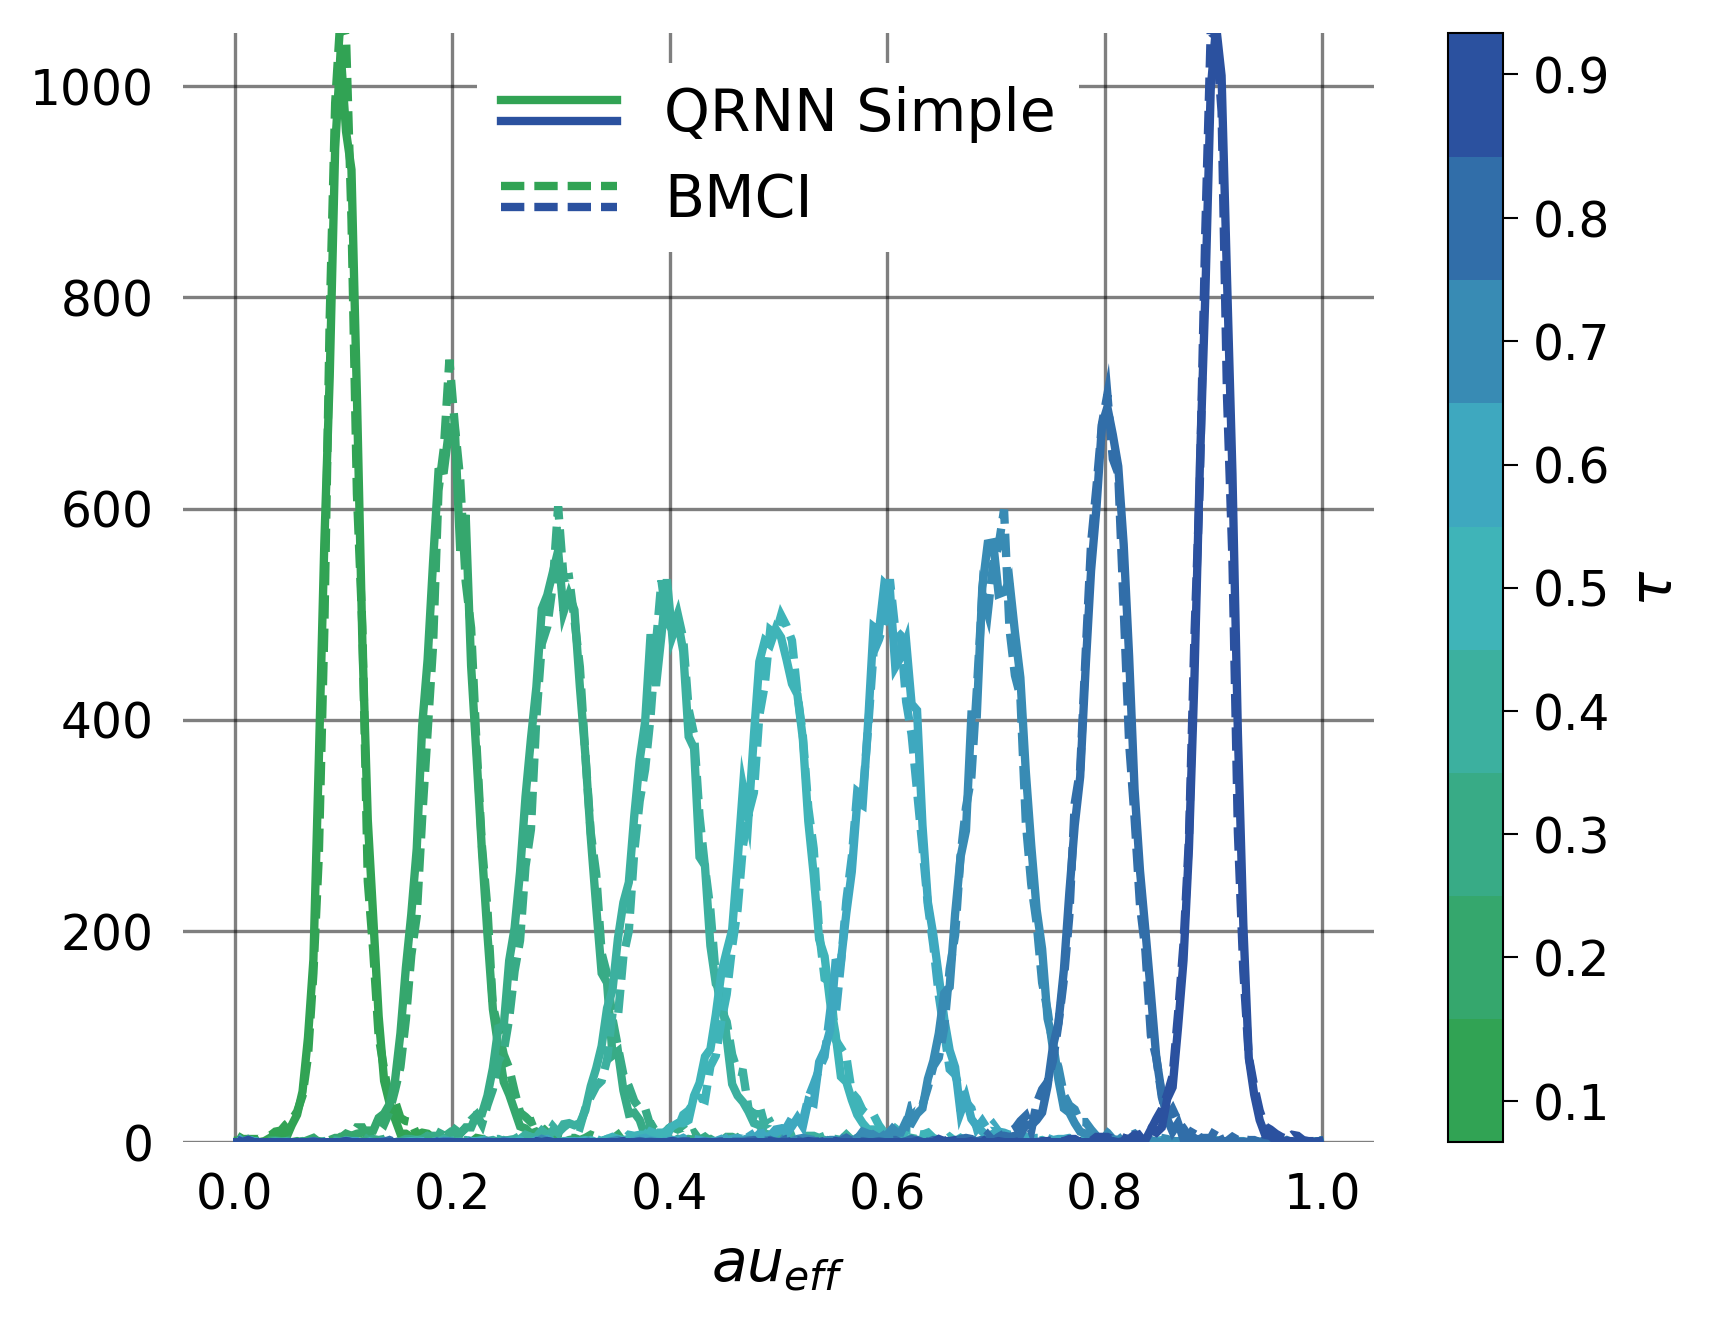

In [53]:
bins = np.linspace(0.0, 1.0, 201)
x = 0.5 * (bins[1:] + bins[:-1])
ptchs_qrnn_ensemble = []
ptchs_qrnn = []
ptchs_bmci = []

for i in range(1, 10):
    cts_qrnn, _ = np.histogram(qdist_qrnn[:, i], bins = bins)
    ps = plt.plot(x, cts_qrnn, c = colors[0][i, :], ls = "-", lw = 2)
    ptchs_qrnn += ps
    cts_qrnn, _ = np.histogram(qdist_qrnn[:, i], bins = bins)
    cts_bmci, _ = np.histogram(qdist_bmci[:, i], bins = bins)
    ps = plt.plot(x, cts_bmci, c = colors[0][i, :], ls = "--", lw = 2)
    ptchs_bmci += ps
sm.set_array(quantiles)
cbar = plt.colorbar(sm, ticks = quantiles[0, 1:10])    
cbar.ax.set_xticklabels([str(x) for x in quantiles])
cbar.ax.set_ylabel(r"$\tau$")
plt.legend(((ptchs_qrnn[0], ptchs_qrnn[-1]),
            (ptchs_bmci[0], ptchs_bmci[-1])),
            ('QRNN simple', 'BMCI'),
            handler_map = {tuple : HandlerTupleVertical()})
plt.ylim([0, 1050])
plt.xlabel("$\tau_{eff}$")
plt.savefig("plots/results_quantiles.pdf")

## Point Data

On the point data test set, we compute the CRPS and quantile losses for both methods. We also investigate the dependence on the size of the training set.

In [46]:
qrnn_5    = QRNN.load("models/qrnn_1_5000")
qrnn_10   = QRNN.load("models/qrnn_1_10000")
qrnn_50   = QRNN.load("models/qrnn_1_50000")
qrnn_100  = QRNN.load("models/qrnn_1_100000")
qrnn_500  = QRNN.load("models/qrnn_1_500000")
qrnn_1000 = QRNN.load("models/qrnn_1_1000000")

In [47]:
qrnn_ensemble_5    = QRNN.load("models/qrnn_5_5000")
qrnn_ensemble_10   = QRNN.load("models/qrnn_5_10000")
qrnn_ensemble_50   = QRNN.load("models/qrnn_5_50000")
qrnn_ensemble_100  = QRNN.load("models/qrnn_5_100000")
qrnn_ensemble_500  = QRNN.load("models/qrnn_5_500000")
qrnn_ensemble_1000 = QRNN.load("models/qrnn_5_1000000")

In [48]:
x_train = np.load("data/x_train_5.npy")
y_train = np.load("data/y_train_5.npy")
bmci_5 = BMCI(x_train[:5000, :], y_train[:5000], np.diag(np.ones(5)))
bmci_10 = BMCI(x_train[:10000, :], y_train[:10000], np.diag(np.ones(5)))
bmci_50 = BMCI(x_train[:50000, :], y_train[:50000], np.diag(np.ones(5)))
bmci_100 = BMCI(x_train[:100000, :], y_train[:100000], np.diag(np.ones(5)))
bmci_500 = BMCI(x_train[:500000, :], y_train[:500000], np.diag(np.ones(5)))
bmci_1000 = BMCI(x_train[:1000000, :], y_train[:1000000], np.diag(np.ones(5)))

### Continuously Ranked Probability Score

The CRPS varies a lot over the training set. We have a look at the mean CRPS score as well as a CRPS score, which is scaled by the CWV value to decrease its influence on the CRPS score.

In [49]:
scores_qrnn = np.stack([qrnn_5.evaluate_crps(x_test_5, y_test_5),
                        qrnn_10.evaluate_crps(x_test_5, y_test_5),
                        qrnn_50.evaluate_crps(x_test_5, y_test_5),
                        qrnn_100.evaluate_crps(x_test_5, y_test_5),
                        qrnn_500.evaluate_crps(x_test_5, y_test_5),
                        qrnn_1000.evaluate_crps(x_test_5, y_test_5)])
scores_scaled_qrnn = scores_qrnn / y_test_5
mean_scores_qrnn = np.mean(scores_qrnn, axis = 1)

In [50]:
scores_qrnn_ensemble = np.stack([qrnn_ensemble_5.evaluate_crps(x_test_5, y_test_5),
                            qrnn_ensemble_10.evaluate_crps(x_test_5, y_test_5),
                            qrnn_ensemble_50.evaluate_crps(x_test_5, y_test_5),
                            qrnn_ensemble_100.evaluate_crps(x_test_5, y_test_5),
                            qrnn_ensemble_500.evaluate_crps(x_test_5, y_test_5),
                            qrnn_ensemble_1000.evaluate_crps(x_test_5, y_test_5)])
scores_scaled_qrnn_ensemble = scores_qrnn / y_test_5
mean_scores_qrnn_ensemble = np.mean(scores_qrnn_ensemble, axis = 1)

In [51]:
scores_bmci = np.stack([bmci_5.crps(x_test_5, y_test_5, x2_max = 5),
                        bmci_10.crps(x_test_5, y_test_5, x2_max = 5),
                        bmci_50.crps(x_test_5, y_test_5, x2_max = 5),
                        bmci_100.crps(x_test_5, y_test_5, x2_max = 5),
                        bmci_500.crps(x_test_5, y_test_5, x2_max = 5),
                        bmci_1000.crps(x_test_5, y_test_5, x2_max = 5)])
scores_scaled_bmci = scores_bmci / y_test_5
mean_scores_bmci = np.nanmean(scores_bmci, axis = 1)

In [83]:
mean_scores_bmci = np.nanmean(scores_bmci, axis = 1)

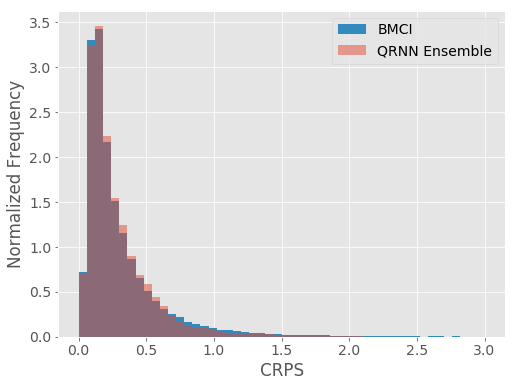

In [120]:
#bins = np.logspace(-2, 1, 21)
bins = np.linspace(0.0, 3., 51)

cts_qrnn          = np.zeros(51)
cts_qrnn_ensemble = np.zeros(51)
cts_bmci          = np.zeros(51)

# n_t = 10^6

#cts_qrnn[1:], _          = np.histogram(scores_qrnn[-1, :], bins = bins, normed = True)
#cts_qrnn_ensemble[1:], _ = np.histogram(scores_qrnn_ensemble[-1, :], bins = bins, normed = True)
#cts_bmci[1:], _          = np.histogram(scores_bmci[-1, :], bins = bins, normed = True)
#plt.hist(scores_qrnn[-1, :], bins = bins, normed = True)
plt.hist(scores_bmci[-1, :][~np.isnan(scores_bmci[-3, :])], bins = bins, normed = True, color = "C1", label = "BMCI")
plt.hist(scores_qrnn_ensemble[-3, :], bins = bins, normed = True, alpha = 0.5, color = "C0", label = "QRNN Ensemble")

x = np.zeros(51)
x[1:] = 0.5 * (bins[1:] + bins[:-1])

#plt.plot(x, cts_qrnn_ensemble, label = "QRNN Ensemble", c = 'C0', lw = 2)
#plt.plot(x, cts_qrnn, label = "QRNN Single", c = 'C0', ls = '--', lw = 2)
#plt.plot(x, cts_bmci, label = "BMCI", c = 'C1', lw = 2)

# n_t = 10^6

plt.xlabel("CRPS")
plt.ylabel("Normalized Frequency")
plt.legend()
#plt.xscale("log")
plt.savefig("plots/crps_100k.pdf")

In [112]:
std_bmci = np.nanstd(scores_bmci, axis = 1)
std_qrnn = np.nanmean(scores_qrnn, axis = 1)
std_qrnn_ensemble = np.nanmean(scores_qrnn_ensemble, axis = 1)

In [111]:
std_bmci

array([ nan,  nan,  nan,  nan,  nan,  nan])

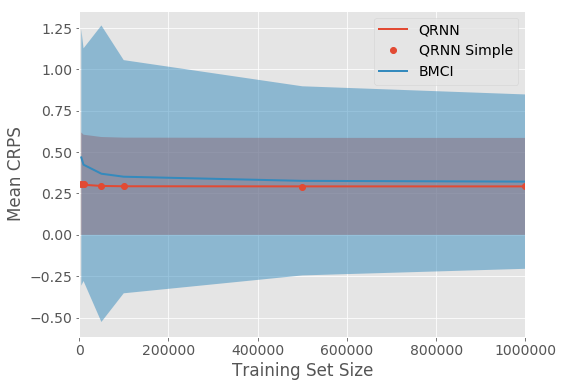

In [118]:
n = np.array([5e3, 1e4, 5e4, 1e5, 5e5, 1e6])
plt.plot(n, mean_scores_qrnn_ensemble, label = "QRNN", c = "C0", lw = 2)
plt.gca().fill_between(n, mean_scores_qrnn_ensemble + std_qrnn_ensemble,
                       mean_scores_qrnn_ensemble - std_qrnn_ensemble,
                       facecolor = "C0", alpha = 0.5)
plt.plot(n, mean_scores_qrnn, label = "QRNN Simple", c = "C0", marker = "o", ls = "", lw = 2)
#plt.gca().fill_between(n, mean_scores_qrnn + std_qrnn,
#                       mean_scores_qrnn - std_qrnn,
#                       facecolor = "C0", alpha = 0.5)
plt.plot(n, mean_scores_bmci, label = "BMCI", c = "C1", lw = 2)
plt.gca().fill_between(n, mean_scores_bmci + std_bmci,
                       mean_scores_bmci - std_bmci,
                       facecolor = "C1", alpha = 0.5)
plt.xlabel("Training Set Size")
plt.xlim([0, 1000000])
plt.ylabel("Mean CRPS")
plt.legend()
plt.savefig("plots/mean_crps.pdf")

### Quantile Loss

In [53]:
from typhon.retrieval.scores import mean_quantile_score, quantile_score

taus = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
y_tau_qrnn = qrnn_1000.predict(x_test_5)
y_tau_bmci = bmci_1000.predict_quantiles(x_test_5, taus)

In [54]:
qs_qrnn_5    = qrnn_5.predict(x_test_5)
qs_qrnn_10   = qrnn_10.predict(x_test_5)
qs_qrnn_50   = qrnn_50.predict(x_test_5)
qs_qrnn_100  = qrnn_100.predict(x_test_5)
qs_qrnn_500  = qrnn_500.predict(x_test_5)
qs_qrnn_1000 = qrnn_1000.predict(x_test_5)
qs_qrnn = np.stack([quantile_score(qs_qrnn_5, y_test_5, taus),
                     quantile_score(qs_qrnn_10, y_test_5, taus),
                     quantile_score(qs_qrnn_50, y_test_5, taus),
                     quantile_score(qs_qrnn_100, y_test_5, taus),
                     quantile_score(qs_qrnn_500, y_test_5, taus),
                     quantile_score(qs_qrnn_1000, y_test_5, taus)])
qs_qrnn_mean = np.mean(qs_qrnn, axis = 1)
qs_qrnn_std  = np.std(qs_qrnn, axis = 1)

In [55]:
qs_qrnn_ensemble_5    = qrnn_ensemble_5.predict(x_test_5)
qs_qrnn_ensemble_10   = qrnn_ensemble_10.predict(x_test_5)
qs_qrnn_ensemble_50   = qrnn_ensemble_50.predict(x_test_5)
qs_qrnn_ensemble_100  = qrnn_ensemble_100.predict(x_test_5)
qs_qrnn_ensemble_500  = qrnn_ensemble_500.predict(x_test_5)
qs_qrnn_ensemble_1000 = qrnn_ensemble_1000.predict(x_test_5)
qs_qrnn_ensemble = np.stack([quantile_score(qs_qrnn_5, y_test_5, taus),
                     quantile_score(qs_qrnn_ensemble_10, y_test_5, taus),
                     quantile_score(qs_qrnn_ensemble_50, y_test_5, taus),
                     quantile_score(qs_qrnn_ensemble_100, y_test_5, taus),
                     quantile_score(qs_qrnn_ensemble_500, y_test_5, taus),
                     quantile_score(qs_qrnn_ensemble_1000, y_test_5, taus)])
qs_qrnn_ensemble_mean = np.mean(qs_qrnn_ensemble, axis = 1)
qs_qrnn_ensemble_std  = np.std(qs_qrnn_ensemble, axis = 1)

In [80]:
qs_qrnn_ensemble_mean = np.mean(qs_qrnn_ensemble, axis = 1)
qs_qrnn_ensemble_std  = np.std(qs_qrnn_ensemble, axis = 1)

In [56]:
qs_bmci_5    = bmci_5.predict_quantiles(x_test_5, taus, x2_max = 5)
qs_bmci_10   = bmci_10.predict_quantiles(x_test_5, taus, x2_max = 5)
qs_bmci_50   = bmci_50.predict_quantiles(x_test_5, taus, x2_max = 5)
qs_bmci_100  = bmci_100.predict_quantiles(x_test_5, taus, x2_max = 5)
qs_bmci_500  = bmci_500.predict_quantiles(x_test_5, taus, x2_max = 5)
qs_bmci_1000 = bmci_1000.predict_quantiles(x_test_5, taus)
mqs_bmci = np.stack([mean_quantile_score(qs_bmci_5, y_test_5, taus),
                    mean_quantile_score(qs_bmci_10, y_test_5, taus),
                    mean_quantile_score(qs_bmci_50, y_test_5, taus),
                    mean_quantile_score(qs_bmci_100, y_test_5, taus),
                    mean_quantile_score(qs_bmci_500, y_test_5, taus),
                    mean_quantile_score(qs_bmci_1000, y_test_5, taus)])

In [57]:
apriori_quantiles = np.percentile(y_test_5, quantiles.ravel() * 100.0)

for j in range(qs_bmci_5.shape[0]):
    if np.any(qs_bmci_5[j, :] != qs_bmci_5[j, :]):
        qs_bmci_5[j, :] = apriori_quantiles
    if np.any(qs_bmci_10[j, :] != qs_bmci_10[j, :]):
        qs_bmci_10[j, :] = apriori_quantiles
    if np.any(qs_bmci_50[j, :] != qs_bmci_50[j, :]):
        qs_bmci_50[j, :] = apriori_quantiles
    if np.any(qs_bmci_100[j, :] != qs_bmci_100[j, :]):
        qs_bmci_100[j, :] = apriori_quantiles

In [64]:
qs_bmci = np.stack([quantile_score(qs_bmci_5, y_test_5, taus),
                     quantile_score(qs_bmci_10, y_test_5, taus),
                     quantile_score(qs_bmci_50, y_test_5, taus),
                     quantile_score(qs_bmci_100, y_test_5, taus),
                     quantile_score(qs_bmci_500, y_test_5, taus),
                     quantile_score(qs_bmci_1000, y_test_5, taus)])
qs_bmci_mean = np.nanmean(qs_bmci, axis = 1)
qs_bmci_std  = np.std(qs_bmci, axis = 1)

In [59]:
qs_bmci_mean = np.nanmean(qs_bmci, axis = 1)
qs_bmci_std  = np.std(qs_bmci, axis = 1)

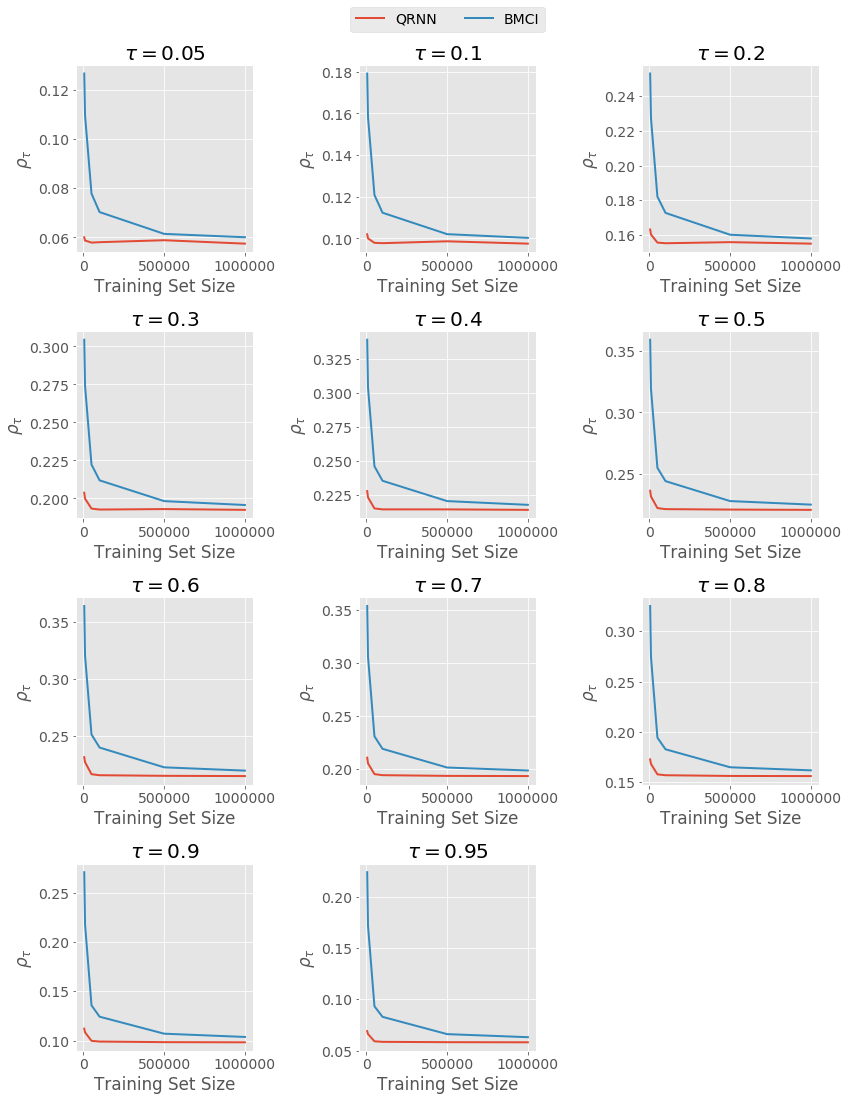

In [81]:
n = np.array([5e3, 1e4, 5e4, 1e5, 5e5, 1e6])
f, axs = plt.subplots(4, 3, figsize = (12, 15))
for i in range(4):
    for j in range(3):
        k = i * 3 + j
        if k < 11:
            axs[i, j].plot(n, qs_qrnn_mean[:, k], c = "C0", label = "QRNN", lw = 2)
            axs[i, j].plot(n, qs_bmci_mean[:, k], c = "C1", label = "BMCI", lw = 2)
            axs[i, j].set_ylabel(r"$\rho_\tau$")
            axs[i, j].set_xlabel("Training Set Size")
            axs[i, j].set_title(r"$\tau = " + str(quantiles[0, k]) + "$")
        else:
            axs[i, j].set_visible(False)
            
axs.ravel()[1].legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.35),
                      fancybox = True, ncol = 2)
plt.tight_layout()
plt.savefig("plots/quantile_loss.pdf", bbox_inches='tight')

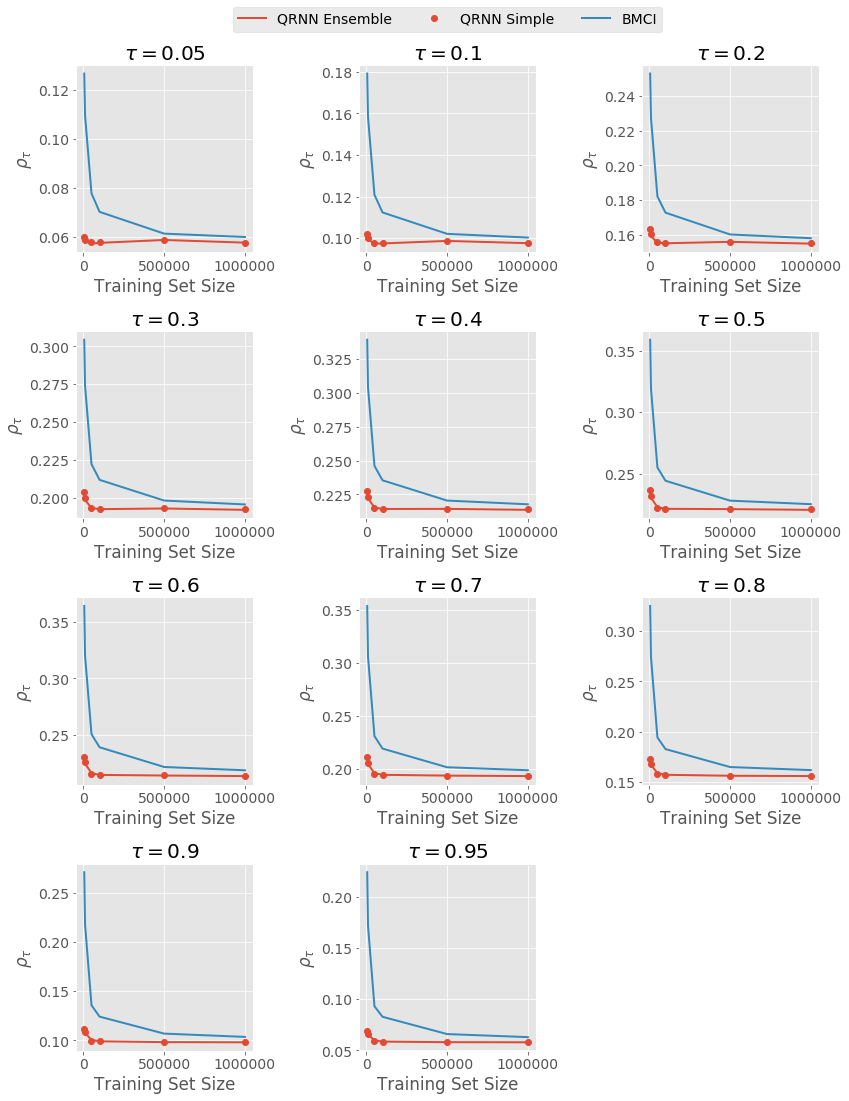

In [82]:
n = np.array([5e3, 1e4, 5e4, 1e5, 5e5, 1e6])
f, axs = plt.subplots(4, 3, figsize = (12, 15))
for i in range(4):
    for j in range(3):
        k = i * 3 + j
        if k < 11:
            axs[i, j].plot(n, qs_qrnn_ensemble_mean[:, k], c = "C0", label = "QRNN Ensemble", lw = 2)
            axs[i, j].plot(n, qs_qrnn_mean[:, k], c = "C0", label = "QRNN Simple", lw = 2,
                           marker = "o", ls = "")
            axs[i, j].plot(n, qs_bmci_mean[:, k], c = "C1", label = "BMCI", lw = 2)
            axs[i, j].set_ylabel(r"$\rho_\tau$")
            axs[i, j].set_xlabel("Training Set Size")
            axs[i, j].set_title(r"$\tau = " + str(quantiles[0, k]) + "$")
        else:
            axs[i, j].set_visible(False)
            
axs.ravel()[1].legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.35),
                      fancybox = True, ncol = 3)
plt.tight_layout()
plt.savefig("plots/quantile_loss.pdf", bbox_inches='tight')

### MAPE

In [1]:
from typhon.retrieval.scores import mape

In [67]:
i = np.argwhere(taus == 0.5)[0]
mape_qrnn = np.stack([mape(qs_qrnn_5[:, i], y_test_5),
                      mape(qs_qrnn_10[:, i], y_test_5),
                      mape(qs_qrnn_50[:, i], y_test_5),
                      mape(qs_qrnn_100[:, i], y_test_5),
                      mape(qs_qrnn_500[:, i], y_test_5),
                      mape(qs_qrnn_1000[:, i], y_test_5)])
mape_qrnn_ensemble = np.stack([mape(qs_qrnn_ensemble_5[:, i], y_test_5),
                      mape(qs_qrnn_ensemble_10[:, i], y_test_5),
                      mape(qs_qrnn_ensemble_50[:, i], y_test_5),
                      mape(qs_qrnn_ensemble_100[:, i], y_test_5),
                      mape(qs_qrnn_ensemble_500[:, i], y_test_5),
                      mape(qs_qrnn_ensemble_1000[:, i], y_test_5)])
mape_bmci = np.stack([mape(qs_bmci_5[:, i], y_test_5),
                      mape(qs_bmci_10[:, i], y_test_5),
                      mape(qs_bmci_50[:, i], y_test_5),
                      mape(qs_bmci_100[:, i], y_test_5),
                      mape(qs_bmci_500[:, i], y_test_5),
                      mape(qs_bmci_1000[:, i], y_test_5)])

In [ ]:
plt.plot(n, mape_qrnn, label = "qrnn", c = "C0", lw = 2)
plt.plot(n, mape_bmci, label = "bmci", c = "C1", lw = 2)
plt.xlabel("Training Set Size")
plt.ylabel("MAPE")
plt.legend()
plt.savefig("plots/mape.pdf")

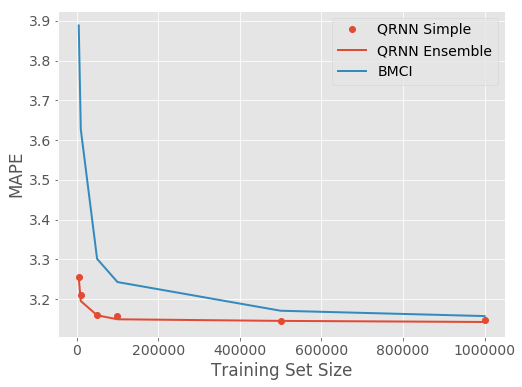

In [76]:
plt.plot(n, mape_qrnn, label = "QRNN Simple", c = "C0", lw = 2, marker = "o", ls = "")
plt.plot(n, mape_qrnn_ensemble, label = "QRNN Ensemble", c = "C0", lw = 2)
plt.plot(n, mape_bmci, label = "BMCI", c = "C1", lw = 2)
plt.xlabel("Training Set Size")
plt.ylabel("MAPE")
plt.legend()
plt.savefig("plots/mape.pdf")